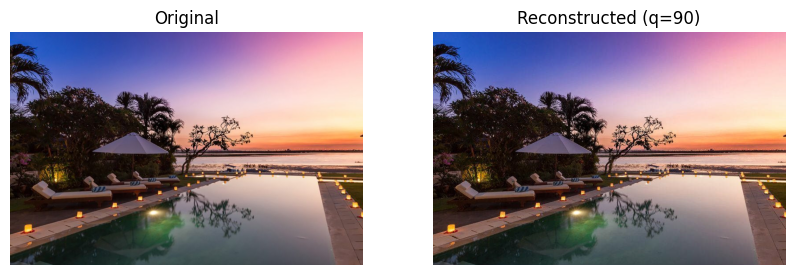

Quality | Encoded Size (bits)
10      | 1510348
30      | 1542836
50      | 1609371
70      | 1662189
90      | 1768820


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.fftpack import dct, idct
from collections import Counter
import heapq

# -------------------------
# DCT and Quantization
# -------------------------
def block_dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def block_idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def dct2(a, block_size=8):
    h, w = a.shape
    out = np.zeros_like(a, dtype=float)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            out[i:i+block_size, j:j+block_size] = block_dct2(a[i:i+block_size, j:j+block_size])
    return out

def idct2(a, block_size=8):
    h, w = a.shape
    out = np.zeros_like(a, dtype=float)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            out[i:i+block_size, j:j+block_size] = block_idct2(a[i:i+block_size, j:j+block_size])
    return out

def quantize(blocks, q_matrix, block_size=8):
    h, w = blocks.shape
    out = np.zeros_like(blocks, dtype=int)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = blocks[i:i+block_size, j:j+block_size]
            out[i:i+block_size, j:j+block_size] = np.round(block / q_matrix[:block.shape[0], :block.shape[1]]).astype(int)
    return out

def dequantize(blocks, q_matrix, block_size=8):
    h, w = blocks.shape
    out = np.zeros_like(blocks, dtype=float)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = blocks[i:i+block_size, j:j+block_size]
            out[i:i+block_size, j:j+block_size] = block * q_matrix[:block.shape[0], :block.shape[1]]
    return out

# Standard JPEG-like quantization matrix
Q_MATRIX = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

# -------------------------
# Huffman Coding
# -------------------------
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(symbols):
    heap = [Node(sym, freq) for sym, freq in symbols.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(node, code='', mapping=None):
    if mapping is None:
        mapping = {}
    if node is not None:
        if node.symbol is not None:
            mapping[node.symbol] = code
        build_huffman_codes(node.left, code+'0', mapping)
        build_huffman_codes(node.right, code+'1', mapping)
    return mapping

def huffman_encode(data):
    freqs = Counter(data.flatten())
    tree = build_huffman_tree(freqs)
    codes = build_huffman_codes(tree)
    encoded = ''.join([codes[sym] for sym in data.flatten()])
    return encoded, codes

# -------------------------
# Compression
# -------------------------
def pad_image(img, block_size=8):
    h, w = img.shape
    new_h = (h + block_size - 1) // block_size * block_size
    new_w = (w + block_size - 1) // block_size * block_size
    padded = np.zeros((new_h, new_w), dtype=img.dtype)
    padded[:h, :w] = img
    return padded, h, w

def compress_channel(channel, q_matrix, quality=50):
    scale = (100 - quality) / 50.0 if quality < 50 else 50.0 / quality
    q_matrix_scaled = np.clip(np.round(q_matrix * scale), 1, 255)

    padded, h, w = pad_image(channel)

    dct_blocks = dct2(padded)
    q_blocks = quantize(dct_blocks, q_matrix_scaled)
    encoded, codes = huffman_encode(q_blocks)

    deq_blocks = dequantize(q_blocks, q_matrix_scaled)
    rec_channel = idct2(deq_blocks)
    rec_channel = np.clip(rec_channel, 0, 255)
    rec_channel = rec_channel[:h, :w]

    return rec_channel, len(encoded)

# -------------------------
# MAIN
# -------------------------
if __name__ == "__main__":
    image_path = "sunsetvilla.jpg"

    img = io.imread(image_path)
    img_ycbcr = color.rgb2ycbcr(img)

    Y, Cb, Cr = img_ycbcr[:,:,0], img_ycbcr[:,:,1], img_ycbcr[:,:,2]

    qualities = [10, 30, 50, 70, 90]
    results = []

    for q in qualities:
        rec_Y, size_Y = compress_channel(Y, Q_MATRIX, quality=q)
        rec_Cb, size_Cb = compress_channel(Cb, Q_MATRIX, quality=q)
        rec_Cr, size_Cr = compress_channel(Cr, Q_MATRIX, quality=q)

        total_size = size_Y + size_Cb + size_Cr
        rec_img_ycbcr = np.stack([rec_Y, rec_Cb, rec_Cr], axis=2)
        rec_img_rgb = color.ycbcr2rgb(rec_img_ycbcr).clip(0,1)

        plt.imsave(f"reconstructed_q{q}.png", rec_img_rgb)

        results.append((q, total_size))

    # Show original vs last reconstructed
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f"Reconstructed (q={qualities[-1]})")
    plt.imshow(rec_img_rgb)
    plt.axis("off")
    plt.show()

    print("Quality | Encoded Size (bits)")
    for q, size in results:
        print(f"{q:<7} | {size}")

✅ Compression Complete!
🔸 PSNR: 4.68 dB
🔸 Compression Ratio: 4.25
🔸 Original Size: 524288 bits
🔸 Compressed Size: 123361 bits


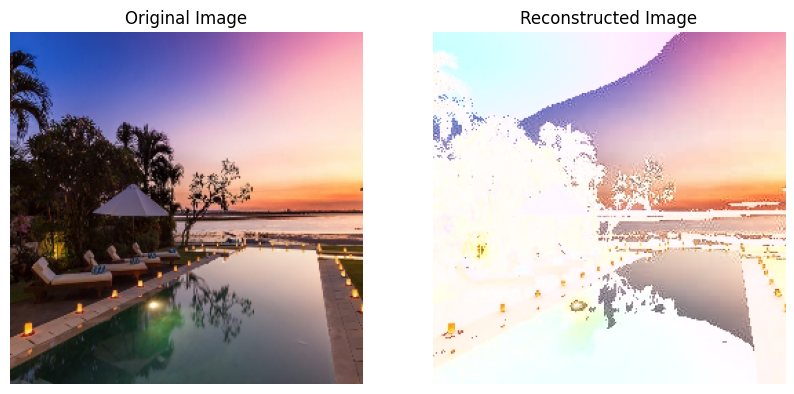

In [7]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
from collections import Counter
import heapq
from math import log10
import matplotlib.pyplot as plt

# --- Load Image ---
img = cv2.imread("sunsetvilla.jpg")
img = cv2.resize(img, (256, 256))

# --- Convert to YCbCr ---
imgYcc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(imgYcc)

# --- Standard JPEG Luminance Quantization Matrix ---
quantMatrix = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

# --- DCT and Quantization ---
def applyDCTandQuantization(channel, blockSize=8):
    h, w = channel.shape
    blocks = []
    for i in range(0, h, blockSize):
        for j in range(0, w, blockSize):
            block = channel[i:i+blockSize, j:j+blockSize] - 128
            dctBlock = dct(dct(block.T, norm='ortho').T, norm='ortho')
            quantBlock = np.round(dctBlock / quantMatrix).astype(int)
            blocks.append(quantBlock)
    return blocks

# --- Huffman Tree Node ---
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

# --- Build Huffman Tree ---
def buildHuffmanTree(freqTable):
    heap = [HuffmanNode(sym, freq) for sym, freq in freqTable.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

# --- Generate Huffman Codes ---
def generateHuffmanCodes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    generateHuffmanCodes(node.left, prefix + "0", codebook)
    generateHuffmanCodes(node.right, prefix + "1", codebook)
    return codebook

# --- Huffman Encode ---
def huffmanEncode(data):
    frequency = Counter(data)
    treeRoot = buildHuffmanTree(frequency)
    codebook = generateHuffmanCodes(treeRoot)
    encodedBits = ''.join(codebook[val] for val in data)
    return encodedBits, codebook

# --- Huffman Decode ---
def huffmanDecode(encodedBits, codebook):
    reverseMap = {v: k for k, v in codebook.items()}
    current = ""
    decoded = []
    for bit in encodedBits:
        current += bit
        if current in reverseMap:
            decoded.append(reverseMap[current])
            current = ""
    return decoded

# --- Encode Y Channel ---
dctBlocksY = applyDCTandQuantization(Y)
flatY = np.array(dctBlocksY).flatten()

encodedBits, huffmanTable = huffmanEncode(flatY.tolist())
decodedY = huffmanDecode(encodedBits, huffmanTable)
decodedY = np.array(decodedY).reshape(-1, 8, 8)

# --- Inverse DCT and Dequantization ---
def reconstructFromDCT(blocks, shape, blockSize=8):
    h, w = shape
    imgRec = np.zeros((h, w))
    idx = 0
    for i in range(0, h, blockSize):
        for j in range(0, w, blockSize):
            block = blocks[idx] * quantMatrix
            idctBlock = idct(idct(block.T, norm='ortho').T, norm='ortho') + 128
            imgRec[i:i+blockSize, j:j+blockSize] = np.clip(idctBlock, 0, 255)
            idx += 1
    return imgRec.astype(np.uint8)

Yrec = reconstructFromDCT(decodedY, Y.shape)

# --- Merge and Convert Back to BGR ---
imgYccRec = cv2.merge((Yrec, Cr, Cb))
imgRec = cv2.cvtColor(imgYccRec, cv2.COLOR_YCrCb2BGR)

# --- PSNR Calculation ---
def calculatePSNR(original, compressed):
    mse = np.mean((original.astype(np.float32) - compressed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * log10((255 ** 2) / mse)

# --- Evaluation ---
psnr = calculatePSNR(img, imgRec)
compressionRatio = (flatY.size * 8) / len(encodedBits)

# --- Results ---
print("✅ Compression Complete!")
print(f"🔸 PSNR: {psnr:.2f} dB")
print(f"🔸 Compression Ratio: {compressionRatio:.2f}")
print(f"🔸 Original Size: {flatY.size * 8} bits")
print(f"🔸 Compressed Size: {len(encodedBits)} bits")

# --- Show Images ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgRec, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()